# Bootstrapping

Repeating the LSMC helps getting a better price estimate and provides statistics of the estimate.
In a more realistic context with a few state variables and many model parameters, we may need more paths to get a satisfactory estimate but more paths can mean running into computer memory issues. 
When adding more paths is not possible, repeating the LSMC method with less paths is a potential solution.

The concept here is also applicable to improving the estimation of the optimal stopping time.
Take, for example, the cross-sectional regression at \(T-1)\.
When repeating $R$ times, we get $R$ sets of $ \beta $.
We can take the average $\bar{\beta}$ to get a better estimate of the value function.

Naïvely, we could simply take the average for each time-step.
However, we know the regression at $T-1$ is biased and we know the bias grows at each time-step.
So, it is better to improve the regression at $T-1$ first, and then proceed to $T-2$.
This is what we do in Letourneau and Stentoft (2019)
In this numerical example, we take the example 4.1.2 with a wider ISD and polynomial of order $M=9$ and apply the bootstrapping method to show how the exercise bnoundary is improved.

## Description of the process
- **forloop t_boot from T to 0**
    - forloop irep from 0 to R-1
        - We simulate for this repeat using the proper initialized random stream
        - We enter the LSMC algorithm: forloop t from T to 0
            - if t_boot < t
                - We do not regress and instead apply the average beta for time $t$.
            - else
                - We regress, store beta, and exit the loop
    - We take the average of betas for time t_boot over all repeats

    

## Reference
Létourneau, P., & Stentoft, L. (2019). Bootstrapping the early exercise boundary in the least-squares monte carlo method. Journal of Risk and Financial Management, 12(4), 190.


In [52]:
# Set the initial variables for the script
import numpy as np
from numpy.linalg import lstsq
import matplotlib.pyplot as plt

# Define parameters
r = 0.06    # Interest rate
K = 1.00    # Strike price
# it is better to work in time-steps than in years
dt = 1/12   # Time-step size in years
nt = 12     # Number of time-steps
T = nt*dt   # Total time to maturity in years

N = 10000      # Number of simulations
M = 9          # polynomial order for cross-sectional regressions
R = 20         # Number of repeats

# For the stock price, here, we will simulate from a Geometric Brownian motion
# We assume a risk-neutral measure
S0 = 1.00   # Initial stock price
sigma = 0.2  # Volatility of the stock


# For reproducibility when doing multiple repeats, we need to get multiple streams of random numbers. I need R streams
SEED = 42  # Seed for reproducibility
SEQ = np.random.SeedSequence(SEED)
SeedSeq = SEQ.spawn(R)
My_R_Streams = [np.random.default_rng(s) for s in SeedSeq]
# Store RNG states before simulation
rng_states = [rng.bit_generator.state for rng in My_R_Streams]
# Because we will loop over the repeats multiple times in the bootstrapping algorithm, 
# we will need to reset the stream each time to ensure we always simulte the same paths
# We don't really need this, though. We could just continue the simulate from the last point.
# However, if we wanted to test convergence as we add more repeats, we would need to reset the RNG state.

# initialize an array to store all average betas for the stopping time approximation
beta_st_average = np.zeros((M+1, nt))

for t_boot in range(nt-1, 0, -1):
    # Restore RNG states to re-simulate from the same point
    for i, rng in enumerate(My_R_Streams):
        rng.bit_generator.state = rng_states[i]
        
    beta_t_boot = np.zeros((M+1, R))  # Store beta coefficients for this bootstrapping iteration

    # loop over all repeats
    for repnum in range(R):
        # We need to clear variables in the loop to avoid carrying over values from previous iterations
        dcf = None
        intrinsic = None
        exec_t = None
        payoff = None
        
        S = np.zeros((N, nt + 1))
        S[:, 0] = np.linspace(0.1, 2, N)
        
        for i in range(1, nt + 1):
            Z = My_R_Streams[repnum].normal(0, 1, N)  # Standard normal random variables
            S[:, i] = S[:, i - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

        """
        sample_size = 20  # Number of paths to plot
        # We want a good representation of the paths, so we will sample 1 path every sample_size
        sample_indices = np.linspace(0, N-1, sample_size, dtype=int)

        # check if sample_size is less than N
        if sample_size > N:
            raise ValueError("sample_size must be less than or equal to N")

        # Now plot the simulated paths if we want too
        times = np.linspace(0, T, nt + 1)

        plt.figure(figsize=(8, 5))
        for i in range(sample_size):
            plt.plot(times, S[sample_indices[i]], marker='o', label=f'Path {sample_indices[i]}')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title(f'Sample of {sample_size} out of {N:,} Simulated Paths')
        plt.grid(True)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plt.tight_layout()
        plt.show()
        """

        # Check what is going on by printing the average stock price at maturity
        # print(f"Average stock price at t=1 for repetition {r+1}: {np.mean(S[:, 1]):.4f}")
        # print(r)
            
        # We will calculate the exercise/intrinsic value for each path at maturity
        # recall that the option to price is a put option
        intrinsic = np.maximum(K - S[:,-1], 0)

        # We create a payoff vector that will contain the discounted exercise value.
        payoff = np.copy(intrinsic)

        # Now we set the vector exec_t to maturity for each path
        exec_t = nt * np.ones((N,), dtype=int)  # All paths would optimally be exercised at time-step 3 (so far))

        # We will do one more thing, for illustration purposes, we will keep the beta coefficients for each time-step in a matrix
        betas = np.zeros((3, nt))  # Store beta coefficients for each time-step

        for t_now in range(nt-1, 0, -1):

            # STEP 1
            dcf = np.exp(-r * dt) * payoff  # Discounted cash flow to time t

            # STEP 2
            itm_paths = np.where(S[:, t_now] < K)[0]  # Identify ITM paths

            # STEP 3
            # Build X matrix for regression (using the stock prices at time t_now)
            # We use a constant, the stock price and the square of the stock price
            x = S[itm_paths, t_now]
            X = np.ones((len(itm_paths), M + 1))
            for j in range(1, M + 1):
                X[:, j] = X[:, j - 1] * x

            # STEP 4
            # Build y vector (the discounted cash flows for ITM paths)
            y = dcf[itm_paths]

            # STEP 5
            # Perform regression to get beta coefficients
            if t_boot<t_now:
                print(f"using previous beta average")
                # If we are not at the last bootstrapping iteration, we will use the average betas from the previous iteration
                beta = beta_st_average[:, t_now]

            else:
                print(f"using lstsq to calculate new beta")
                # If we are at the last bootstrapping iteration, we will perform the regression
                # and store the beta coefficients for this time-step
                beta = lstsq(X, y, rcond=None)[0]
                beta_t_boot[:, repnum] = beta
                # now we can exit the loop and continue with the next repeat
                # """
                # DEBUG
                # """
                # if t_now == nt - 1:
                #     # print top 5 lines of matrix X and y
                #     print("DEBUG: X matrix (first 5 rows):")
                #     print(X[:5])
                #     print("DEBUG: y vector (first 5 values):")
                #     print(y[:5])
                #     print("DEBUG: beta coefficients:")
                #     print(beta)
                # Turns out, up until here, everything is the same as in the previous code.

                # print(beta_t_boot[:, repnum])
                break

            # STEP 6
            # Calculate y_hat to approximate the holding value function
            y_hat = X @ beta

            # Update the payoff for exercised paths to be the current intrinsic value
            intrinsic[itm_paths] = np.maximum(K - S[itm_paths, t_now], 0)

            # STEP 7
            # Update the optimal exercise time for each path
            exec_t[itm_paths] = np.where(y_hat < intrinsic[itm_paths], t_now, exec_t[itm_paths])
            payoff = np.where(exec_t == t_now, intrinsic, dcf)
    
    # We can take the average of the beta coefficients across all repeats
    beta_st_average[:, t_boot] = np.mean(beta_t_boot, axis=1)
    # """Debug"""
    # print(beta_t_boot)

print(beta_st_average.transpose())
    
    

using lstsq to calculate new beta
using lstsq to calculate new beta
using lstsq to calculate new beta
using lstsq to calculate new beta
using lstsq to calculate new beta
using lstsq to calculate new beta
using lstsq to calculate new beta
using lstsq to calculate new beta
using lstsq to calculate new beta
using lstsq to calculate new beta
using lstsq to calculate new beta
using lstsq to calculate new beta
using lstsq to calculate new beta
using lstsq to calculate new beta
using lstsq to calculate new beta
using lstsq to calculate new beta
using lstsq to calculate new beta
using lstsq to calculate new beta
using lstsq to calculate new beta
using lstsq to calculate new beta
using previous beta average
using lstsq to calculate new beta
using previous beta average
using lstsq to calculate new beta
using previous beta average
using lstsq to calculate new beta
using previous beta average
using lstsq to calculate new beta
using previous beta average
using lstsq to calculate new beta
using prev

Something is not right. perhaps I should plot the exercise frontier for each repeat and see if this works or not

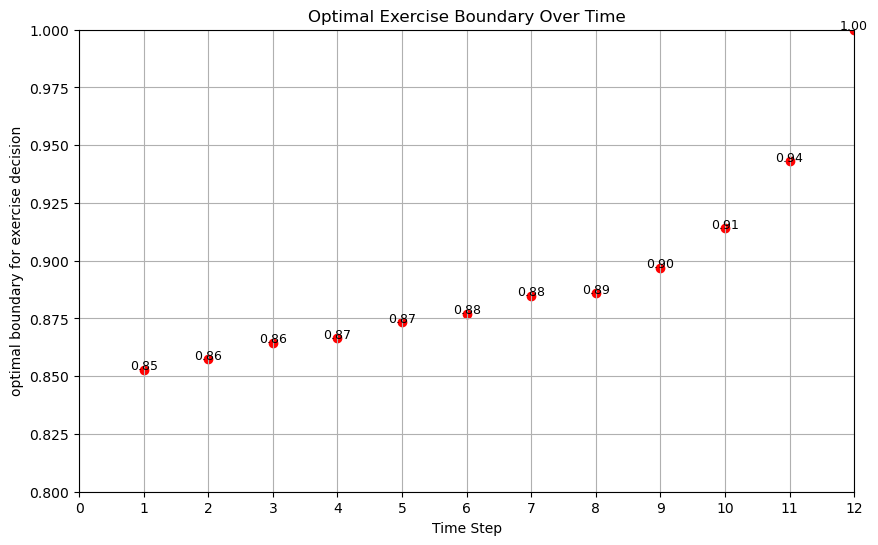

In [53]:
# Now, I want to loop through the betas and locate the intersection of the polynomial with the exercise value
# This will give use the optimal exercise boundary for this option

# For each time-step, beta defines a polynomial or second degree.
# The exercise value is polynomial of degree 1, so we can find the intersection points
import numpy.polynomial.polynomial as P
import matplotlib.pyplot as plt

# Define the exercise value polynomial coefficients
exercise_value_coeffs = [K, -1]  # Coefficients for the line y = K - x

# We will keep the intersection points for each time-step
intersection_points = []

# Loop through the betas and find the intersection points
for t in range(1, nt):
    # Get the beta coefficients for this time-step
    beta = beta_st_average[:, t]
    # print(f"\nTime-Step {t} Beta Coefficients:\n", np.array2string(beta, formatter={'float_kind':lambda x: f"{x:.4f}"}))

    # Define the polynomial for the option value
    option_value_poly = P.Polynomial(beta)
    option_execs_poly = P.Polynomial(exercise_value_coeffs)  # Second degree polynomial for the option value

    intersection = P.polyroots((option_value_poly - option_execs_poly).coef)
    # print(f"Intersection Points for Time-Step {t}:\n", np.array2string(intersection, formatter={'float_kind':lambda x: f"{x:.4f}"}))

    # I will only keep the intersection points where the x-coordinate is less than or equal to K
    intersection = intersection[intersection.real <= K]
    # If there are two intersection points, we will keep the one that is closest to K
    if len(intersection) > 1:
        intersection = intersection[np.abs(intersection - K).argmin()]
    elif len(intersection) == 0:
        intersection = np.array([])

    # Keep only the real roots
    intersection = intersection[intersection.imag == 0].real

    intersection_points.append(intersection)

# We know the optimal exercise at nt is at K, so we will append it to the intersection points
intersection_points.append(np.array([K]))

# Collect all valid intersection points and their time steps
x_vals = []
y_vals = []
for t, intersection in enumerate(intersection_points, start=1):
    if intersection.size > 0:
        x_vals.append(t)
        y_vals.append(intersection[0])

plt.figure(figsize=(10, 6))
plt.scatter(x_vals, y_vals, color='red')
for t, y in zip(x_vals, y_vals):
    plt.text(t, y, f"{y:.2f}", fontsize=9, ha='center')
plt.ylim(0.8, 1)
plt.xlim(0, nt)
plt.xticks(np.arange(0, nt + 1, 1))
plt.xlabel('Time Step')
plt.ylabel('optimal boundary for exercise decision')
plt.title('Optimal Exercise Boundary Over Time')
plt.grid(True)
plt.show()